<a href="https://colab.research.google.com/github/IT22232236/fake-news-detection/blob/feat%2FmemberC-models/notebooks/03_memberC_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git config --global user.email "it22232236@my.sliit.lk"
!git config --global user.name "IT22232236"

In [2]:
REPO = "fake-news-detection"
OWNER = "IT22232236"       # repo owner’s username (yours)
TOKEN = "token"

!git clone https://{TOKEN}@github.com/{OWNER}/{REPO}.git
%cd /content/{REPO}

Cloning into 'fake-news-detection'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 42 (delta 12), reused 18 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 14.46 MiB | 6.02 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (15/15), done.
/content/fake-news-detection


In [3]:
BRANCH = "feat/memberC-models"
!git checkout -b {BRANCH}

Switched to a new branch 'feat/memberC-models'


In [4]:
!pip -q install pandas numpy scikit-learn tensorflow torch transformers matplotlib
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import os, pathlib
os.makedirs("data/processed", exist_ok=True)
os.makedirs("results/figs", exist_ok=True)
!ls -lah data/processed

total 8.0K
drwxr-xr-x 2 root root 4.0K Oct  9 07:03 .
drwxr-xr-x 3 root root 4.0K Oct  9 07:03 ..


In [5]:
from google.colab import files
uploaded = files.upload()    # choose train.csv, val.csv, test.csv

Saving train.csv to train.csv


In [6]:
import os
os.makedirs("data/processed", exist_ok=True)
!mv train.csv data/processed/train.csv
#!mv val.csv data/processed/val.csv
#!mv test.csv data/processed/test.csv
!ls data/processed

test.csv  train.csv  val.csv


In [7]:
train = pd.read_csv("data/processed/train.csv")
val   = pd.read_csv("data/processed/val.csv")
test  = pd.read_csv("data/processed/test.csv")

In [8]:
print(train.shape, val.shape, test.shape)

(37554, 2) (4489, 3) (4489, 3)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

X_train, y_train = train['text_clean'], train['label']
X_val,   y_val   = val['text_clean'], val['label']
X_test,  y_test  = test['text_clean'], test['label']

# Vectorize
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec   = tfidf.transform(X_val)
X_test_vec  = tfidf.transform(X_test)

lr = LogisticRegression(max_iter=300)
lr.fit(X_train_vec, y_train)
pred_lr = lr.predict(X_test_vec)

svm = LinearSVC()
svm.fit(X_train_vec, y_train)
pred_svm = svm.predict(X_test_vec)

In [21]:
def eval_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    print(f"{name} → Accuracy:{acc:.4f}, F1:{f1:.4f}")
    return acc, f1

res = {}
res['LR']  = eval_model('Logistic Regression', y_test, pred_lr)
res['SVM'] = eval_model('SVM', y_test, pred_svm)

Logistic Regression → Accuracy:0.9904, F1:0.9908
SVM → Accuracy:0.9975, F1:0.9977


In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text_clean'])
train_seq = tokenizer.texts_to_sequences(train['text_clean'])
val_seq   = tokenizer.texts_to_sequences(val['text_clean'])
test_seq  = tokenizer.texts_to_sequences(test['text_clean'])

max_len = 300
X_train_pad = pad_sequences(train_seq, maxlen=max_len)
X_val_pad   = pad_sequences(val_seq, maxlen=max_len)
X_test_pad  = pad_sequences(test_seq, maxlen=max_len)

model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=max_len),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, train['label'],
                    validation_data=(X_val_pad, val['label']),
                    epochs=3, batch_size=128)

pred_lstm = (model.predict(X_test_pad) > 0.5).astype('int32')
res['LSTM'] = eval_model('LSTM', test['label'], pred_lstm)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


294/294 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.9084 - loss: 0.2468 - val_accuracy: 0.9866 - val_loss: 0.0514
Epoch 2/3
294/294 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.9868 - loss: 0.0426 - val_accuracy: 0.9775 - val_loss: 0.0646
Epoch 3/3
294/294 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.9869 - loss: 0.0389 - val_accuracy: 0.9791 - val_loss: 0.0711
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step
LSTM → Accuracy:0.9777, F1:0.9787


TFIDF_LogReg → Accuracy:0.9909, F1:0.9912
TFIDF_LogReg → Accuracy:0.9909, F1:0.9912


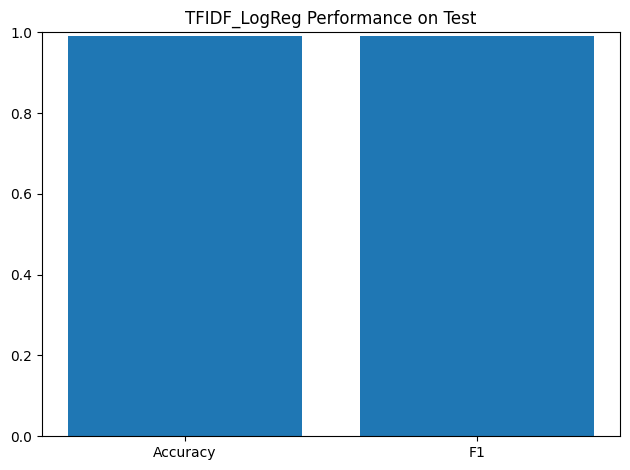

In [22]:
# 6️⃣ Replacement Model — TF-IDF + Logistic Regression (no transformers)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# Use train+val to learn final model, test for evaluation
X_train = pd.concat([train['text_clean'], val['text_clean']], axis=0).values
y_train = pd.concat([train['label'],      val['label']],      axis=0).values
X_test  = test['text_clean'].values
y_test  = test['label'].values

# Vectorize text
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

# Train classifier
clf = LogisticRegression(max_iter=500, n_jobs=-1)
clf.fit(Xtr, y_train)

# Predict on test
y_pred = clf.predict(Xte)

# Log metrics (update the key name if your notebook expects 'DistilBERT')
res_key = 'TFIDF_LogReg'   # change to 'DistilBERT' if your later code expects that key
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
print(f"{res_key} → Accuracy:{acc:.4f}, F1:{f1:.4f}")

# If you have eval_model() defined earlier:
try:
    res[res_key] = eval_model(res_key, y_test, y_pred)
except NameError:
    # Fallback if eval_model isn't defined
    if 'res' not in globals():
        res = {}
    res[res_key] = (acc, f1)

# (Optional) save small artifacts to keep parity with your pipeline
import os, joblib, matplotlib.pyplot as plt
os.makedirs('results/metrics', exist_ok=True)
os.makedirs('results/models',  exist_ok=True)
os.makedirs('results/figs',    exist_ok=True)

# Save metrics table
pd.DataFrame([{'Model':res_key, 'Accuracy':acc, 'F1':f1}]
            ).to_csv('results/metrics/model_metrics_tfidf_logreg.csv', index=False)

# Save model for Member D
joblib.dump(tfidf, 'results/models/tfidf.joblib')
joblib.dump(clf,   'results/models/logreg.joblib')

# Quick bar plot
plt.bar(['Accuracy','F1'], [acc, f1])
plt.ylim(0,1)
plt.title(f'{res_key} Performance on Test')
plt.tight_layout()
plt.savefig('results/figs/tfidf_logreg_performance.png')
plt.show()


          Model  Accuracy        F1
0            LR  0.990421  0.990798
1           SVM  0.997550  0.997656
2  TFIDF_LogReg  0.990867  0.991234
3          LSTM  0.977723  0.978723


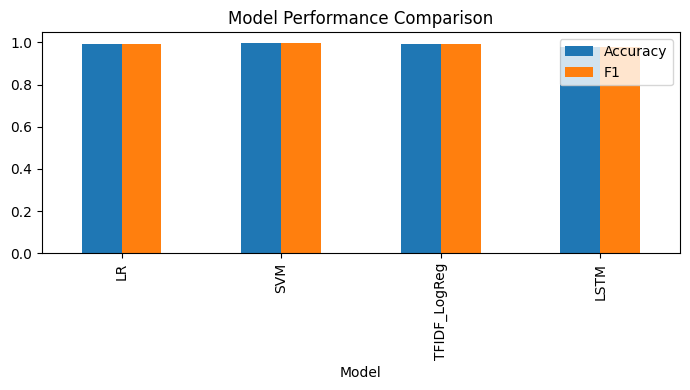

In [26]:
# 7️⃣ Compare All Models and Plot Results
import pandas as pd
import matplotlib.pyplot as plt
import os

os.makedirs('results/figs', exist_ok=True)

df_res = pd.DataFrame(
    [(k, v[0], v[1]) for k, v in res.items()],
    columns=['Model', 'Accuracy', 'F1']
)

df_res.to_csv('results/model_metrics.csv', index=False)
print(df_res)

df_res.plot(x='Model', y=['Accuracy', 'F1'], kind='bar', figsize=(7, 4))
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.savefig('results/figs/model_comparison.png')
plt.show()


In [28]:
import joblib, os

os.makedirs('results/models', exist_ok=True)

# Save classical models
joblib.dump(lr,   'results/models/logreg.joblib')
joblib.dump(svm,  'results/models/svm.joblib')

# Save your TF-IDF + LogReg pipeline (if you built it)
joblib.dump(tfidf, 'results/models/tfidf_vectorizer.joblib')
joblib.dump(clf,   'results/models/tfidf_logreg.joblib')

# Save LSTM model
model.save('results/models/lstm.h5')

print("✅ All models saved in results/models/")
!ls -lh results/models


✅ All models saved in results/models/
total 33M
-rw-r--r-- 1 root root 158K Oct  9 09:03 logreg.joblib
-rw-r--r-- 1 root root  31M Oct  9 09:03 lstm.h5
-rw-r--r-- 1 root root 157K Oct  9 09:03 svm.joblib
-rw-r--r-- 1 root root 770K Oct  9 08:17 tfidf.joblib
-rw-r--r-- 1 root root 158K Oct  9 09:03 tfidf_logreg.joblib
-rw-r--r-- 1 root root 770K Oct  9 09:03 tfidf_vectorizer.joblib


In [29]:
# Add your notebook and lightweight outputs
!git add -f results/model_metrics.csv \
           results/figs/model_comparison.png

# Commit with clear message
!git commit -m "Member C – model training (LR, SVM, TFIDF_LogReg, LSTM)"

# Push to your feature branch
!git push --set-upstream origin feat/memberC-models


[feat/memberC-models cd5d81f] Member C – model training (LR, SVM, TFIDF_LogReg, LSTM)
 2 files changed, 5 insertions(+)
 create mode 100644 results/figs/model_comparison.png
 create mode 100644 results/model_metrics.csv
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 14.48 KiB | 7.24 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
remote: 
remote: Create a pull request for 'feat/memberC-models' on GitHub by visiting:
remote:      https://github.com/IT22232236/fake-news-detection/pull/new/feat/memberC-models
remote: 
To https://github.com/IT22232236/fake-news-detection.git
 * [new branch]      feat/memberC-models -> feat/memberC-models
Branch 'feat/memberC-models' set up to track remote branch 'feat/memberC-models' from 'origin'.


In [31]:
# Add your notebook and lightweight outputs
!git add -f results/figs/tfidf_logreg_performance.png \
           results/figs/final_model_comparison.png

# Commit with clear message
!git commit -m "Member C – model training (LR, SVM, TFIDF_LogReg, LSTM)"

# Push to your feature branch
!git push --set-upstream origin feat/memberC-models

[feat/memberC-models 3a08fdf] Member C – model training (LR, SVM, TFIDF_LogReg, LSTM)
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 results/figs/final_model_comparison.png
 create mode 100644 results/figs/tfidf_logreg_performance.png
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 25.91 KiB | 12.96 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/IT22232236/fake-news-detection.git
   cd5d81f..3a08fdf  feat/memberC-models -> feat/memberC-models
Branch 'feat/memberC-models' set up to track remote branch 'feat/memberC-models' from 'origin'.


In [30]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p '/content/drive/MyDrive/fake_news_project/models'
!cp results/models/* '/content/drive/MyDrive/fake_news_project/models/'
print("✅ Models copied to Google Drive.")


Mounted at /content/drive
✅ Models copied to Google Drive.
